In [1]:
from __future__ import print_function

import logging
import sys
root_logger = logging.getLogger()
stdout_handler = logging.StreamHandler(sys.stdout)
root_logger.addHandler(stdout_handler)
root_logger.setLevel(logging.DEBUG)

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=10000):
  batch_size = min(X.shape[0], batch_size)
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(X),
    batch_size=batch_size,
    label_name='data')

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### We'll write autoencoders in MXNet.

Let's start with simple autoencoder - no regularization or fancy optimization techniques.

In [3]:
input_size = 784
hidden_size = 128 

In [4]:
def autoencoder_loss():
  data = sym.Variable('data')
  weights = sym.Variable(name='weighs', shape=(input_size, hidden_size), init=mx.init.Xavier())
  hid_in = sym.dot(data, weights, name='hidden_in')
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=hid_out, label=data)
  )

autoencoder = mod.Module(symbol=autoencoder_loss(), label_names=['data'])

In [5]:
%time autoencoder.fit(train_iter, eval_data=valid_iter, num_epoch=200, eval_metric='rmse', optimizer_params={'learning_rate': 0.5})

Epoch[0] Train-rmse=0.941132
Epoch[0] Time cost=1.269
Epoch[0] Validation-rmse=1.030044
Epoch[1] Train-rmse=0.931633
Epoch[1] Time cost=1.229
Epoch[1] Validation-rmse=1.020772
Epoch[2] Train-rmse=0.924094
Epoch[2] Time cost=1.209
Epoch[2] Validation-rmse=1.013331
Epoch[3] Train-rmse=0.917874
Epoch[3] Time cost=1.184
Epoch[3] Validation-rmse=1.007179
Epoch[4] Train-rmse=0.912575
Epoch[4] Time cost=1.162
Epoch[4] Validation-rmse=1.001960
Epoch[5] Train-rmse=0.907937
Epoch[5] Time cost=1.203
Epoch[5] Validation-rmse=0.997429
Epoch[6] Train-rmse=0.903780
Epoch[6] Time cost=1.156
Epoch[6] Validation-rmse=0.993411
Epoch[7] Train-rmse=0.899978
Epoch[7] Time cost=1.324
Epoch[7] Validation-rmse=0.989782
Epoch[8] Train-rmse=0.896441
Epoch[8] Time cost=1.147
Epoch[8] Validation-rmse=0.986451
Epoch[9] Train-rmse=0.893105
Epoch[9] Time cost=1.192
Epoch[9] Validation-rmse=0.983345
Epoch[10] Train-rmse=0.889921
Epoch[10] Time cost=1.158
Epoch[10] Validation-rmse=0.980413
Epoch[11] Train-rmse=0.886853

Epoch[90] Validation-rmse=0.851277
Epoch[91] Train-rmse=0.741138
Epoch[91] Time cost=1.167
Epoch[91] Validation-rmse=0.850434
Epoch[92] Train-rmse=0.740156
Epoch[92] Time cost=1.172
Epoch[92] Validation-rmse=0.849599
Epoch[93] Train-rmse=0.739182
Epoch[93] Time cost=1.164
Epoch[93] Validation-rmse=0.848771
Epoch[94] Train-rmse=0.738216
Epoch[94] Time cost=1.154
Epoch[94] Validation-rmse=0.847950
Epoch[95] Train-rmse=0.737257
Epoch[95] Time cost=1.179
Epoch[95] Validation-rmse=0.847135
Epoch[96] Train-rmse=0.736306
Epoch[96] Time cost=1.150
Epoch[96] Validation-rmse=0.846327
Epoch[97] Train-rmse=0.735363
Epoch[97] Time cost=1.171
Epoch[97] Validation-rmse=0.845526
Epoch[98] Train-rmse=0.734427
Epoch[98] Time cost=1.153
Epoch[98] Validation-rmse=0.844732
Epoch[99] Train-rmse=0.733498
Epoch[99] Time cost=1.156
Epoch[99] Validation-rmse=0.843944
Epoch[100] Train-rmse=0.732577
Epoch[100] Time cost=1.162
Epoch[100] Validation-rmse=0.843163
Epoch[101] Train-rmse=0.731662
Epoch[101] Time cost=

Epoch[178] Time cost=1.169
Epoch[178] Validation-rmse=0.797075
Epoch[179] Train-rmse=0.677107
Epoch[179] Time cost=1.167
Epoch[179] Validation-rmse=0.796628
Epoch[180] Train-rmse=0.676572
Epoch[180] Time cost=1.139
Epoch[180] Validation-rmse=0.796183
Epoch[181] Train-rmse=0.676039
Epoch[181] Time cost=1.173
Epoch[181] Validation-rmse=0.795741
Epoch[182] Train-rmse=0.675510
Epoch[182] Time cost=1.182
Epoch[182] Validation-rmse=0.795302
Epoch[183] Train-rmse=0.674984
Epoch[183] Time cost=1.158
Epoch[183] Validation-rmse=0.794865
Epoch[184] Train-rmse=0.674460
Epoch[184] Time cost=1.176
Epoch[184] Validation-rmse=0.794430
Epoch[185] Train-rmse=0.673940
Epoch[185] Time cost=1.161
Epoch[185] Validation-rmse=0.793998
Epoch[186] Train-rmse=0.673423
Epoch[186] Time cost=1.187
Epoch[186] Validation-rmse=0.793569
Epoch[187] Train-rmse=0.672909
Epoch[187] Time cost=1.155
Epoch[187] Validation-rmse=0.793143
Epoch[188] Train-rmse=0.672398
Epoch[188] Time cost=1.138
Epoch[188] Validation-rmse=0.7927

In [6]:
reconstructed_digits = autoencoder.predict(valid_iter)
autoencoder.score(test_iter, eval_metric='rmse')

[('rmse', 1.0870645046234131)]

In [7]:
def plot_two_img_rows(X1, X2, title, j=5):
  f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()

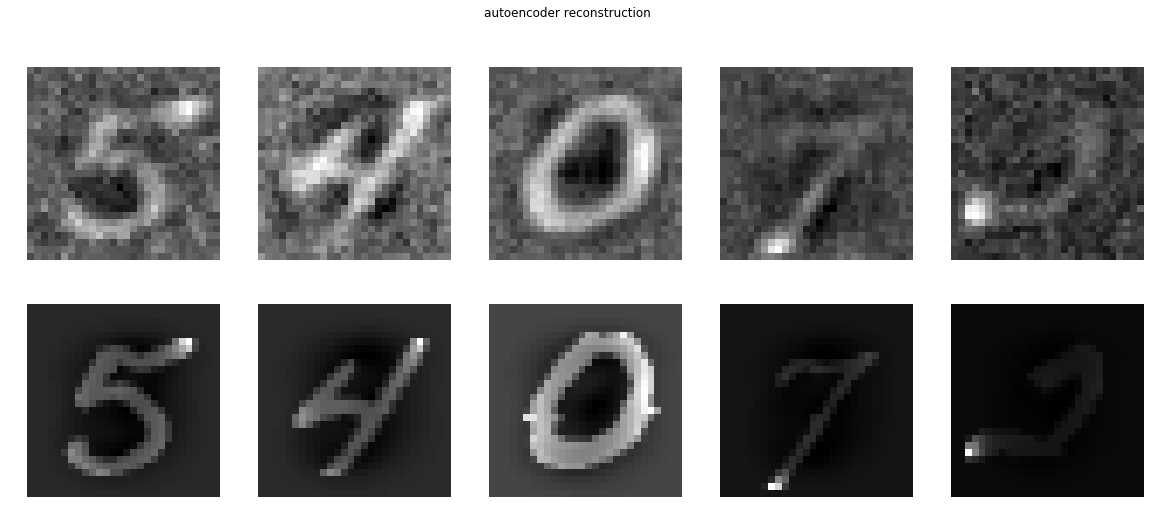

In [8]:
reconstructed_digit_examples = reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(reconstructed_digit_examples[:10], X_valid[:10], 'autoencoder reconstruction')

### Adding dropout 

In [27]:
def dropout_autoencoder_loss(p):
  data = sym.Variable('data')
  weights = sym.Dropout(
    p=p, 
    data=sym.Variable(
       name='weighs',
       shape=(input_size, hidden_size),
       init=mx.init.Xavier(),
       dtype='float32')
  )
  hid_in = sym.dot(data, weights, name='hidden_in')
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=hid_out, label=data)
  )

dropout_autoencoder = mod.Module(symbol=dropout_autoencoder_loss(p=0.33), label_names=['data'])

In [28]:
%time dropout_autoencoder.fit(train_iter, eval_data=valid_iter, num_epoch=200, eval_metric='rmse', optimizer_params={'learning_rate': 0.5})

Epoch[0] Train-rmse=1.013617
Epoch[0] Time cost=1.165
Epoch[0] Validation-rmse=1.021797
Epoch[1] Train-rmse=0.994011
Epoch[1] Time cost=1.194
Epoch[1] Validation-rmse=1.013024
Epoch[2] Train-rmse=0.982094
Epoch[2] Time cost=1.379
Epoch[2] Validation-rmse=1.007365
Epoch[3] Train-rmse=0.973184
Epoch[3] Time cost=1.218
Epoch[3] Validation-rmse=1.003218
Epoch[4] Train-rmse=0.967619
Epoch[4] Time cost=1.150
Epoch[4] Validation-rmse=1.000353
Epoch[5] Train-rmse=0.962369
Epoch[5] Time cost=1.196
Epoch[5] Validation-rmse=0.998364
Epoch[6] Train-rmse=0.957582
Epoch[6] Time cost=1.379
Epoch[6] Validation-rmse=0.996723
Epoch[7] Train-rmse=0.953478
Epoch[7] Time cost=1.358
Epoch[7] Validation-rmse=0.995448
Epoch[8] Train-rmse=0.950763
Epoch[8] Time cost=1.136
Epoch[8] Validation-rmse=0.994515
Epoch[9] Train-rmse=0.949338
Epoch[9] Time cost=1.156
Epoch[9] Validation-rmse=0.993729
Epoch[10] Train-rmse=0.947018
Epoch[10] Time cost=1.733
Epoch[10] Validation-rmse=0.992826
Epoch[11] Train-rmse=0.945306

Epoch[90] Validation-rmse=0.908649
Epoch[91] Train-rmse=0.849627
Epoch[91] Time cost=1.581
Epoch[91] Validation-rmse=0.907954
Epoch[92] Train-rmse=0.848838
Epoch[92] Time cost=1.810
Epoch[92] Validation-rmse=0.907035
Epoch[93] Train-rmse=0.847826
Epoch[93] Time cost=1.792
Epoch[93] Validation-rmse=0.905839
Epoch[94] Train-rmse=0.846888
Epoch[94] Time cost=1.316
Epoch[94] Validation-rmse=0.904871
Epoch[95] Train-rmse=0.846842
Epoch[95] Time cost=1.185
Epoch[95] Validation-rmse=0.904140
Epoch[96] Train-rmse=0.844965
Epoch[96] Time cost=1.493
Epoch[96] Validation-rmse=0.903372
Epoch[97] Train-rmse=0.843505
Epoch[97] Time cost=1.379
Epoch[97] Validation-rmse=0.902444
Epoch[98] Train-rmse=0.842540
Epoch[98] Time cost=1.644
Epoch[98] Validation-rmse=0.901406
Epoch[99] Train-rmse=0.842753
Epoch[99] Time cost=1.534
Epoch[99] Validation-rmse=0.900701
Epoch[100] Train-rmse=0.840606
Epoch[100] Time cost=1.463
Epoch[100] Validation-rmse=0.899741
Epoch[101] Train-rmse=0.839603
Epoch[101] Time cost=

Epoch[178] Time cost=1.327
Epoch[178] Validation-rmse=0.848187
Epoch[179] Train-rmse=0.782338
Epoch[179] Time cost=1.352
Epoch[179] Validation-rmse=0.847722
Epoch[180] Train-rmse=0.780623
Epoch[180] Time cost=1.379
Epoch[180] Validation-rmse=0.847251
Epoch[181] Train-rmse=0.780785
Epoch[181] Time cost=1.227
Epoch[181] Validation-rmse=0.846813
Epoch[182] Train-rmse=0.780284
Epoch[182] Time cost=1.318
Epoch[182] Validation-rmse=0.846482
Epoch[183] Train-rmse=0.779620
Epoch[183] Time cost=1.291
Epoch[183] Validation-rmse=0.846246
Epoch[184] Train-rmse=0.779596
Epoch[184] Time cost=1.220
Epoch[184] Validation-rmse=0.845484
Epoch[185] Train-rmse=0.779222
Epoch[185] Time cost=1.285
Epoch[185] Validation-rmse=0.844789
Epoch[186] Train-rmse=0.778304
Epoch[186] Time cost=1.257
Epoch[186] Validation-rmse=0.844412
Epoch[187] Train-rmse=0.777458
Epoch[187] Time cost=1.222
Epoch[187] Validation-rmse=0.843824
Epoch[188] Train-rmse=0.776875
Epoch[188] Time cost=1.321
Epoch[188] Validation-rmse=0.8434

In [29]:
dropout_reconstructed_digits = dropout_autoencoder.predict(valid_iter)
dropout_autoencoder.score(test_iter, eval_metric='rmse')

[('rmse', 1.1386623382568359)]

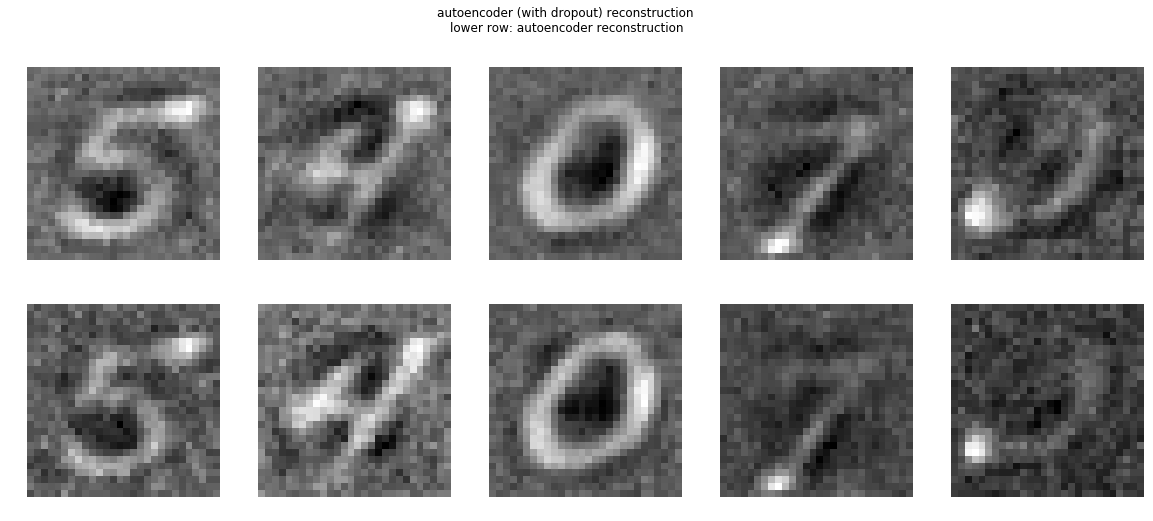

In [33]:
dropout_reconstructed_digit_examples = dropout_reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(dropout_reconstructed_digit_examples[:10], reconstructed_digit_examples[:10], 'autoencoder (with dropout) reconstruction \nlower row: autoencoder reconstruction')